In [71]:
# Imported library for current project

import numpy as np

import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-JPY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [72]:
# Currency pair exchange rates for CAD/JPY

cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [73]:
# Trimmed the dataset to begin on January 1st, 1990

cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]

cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

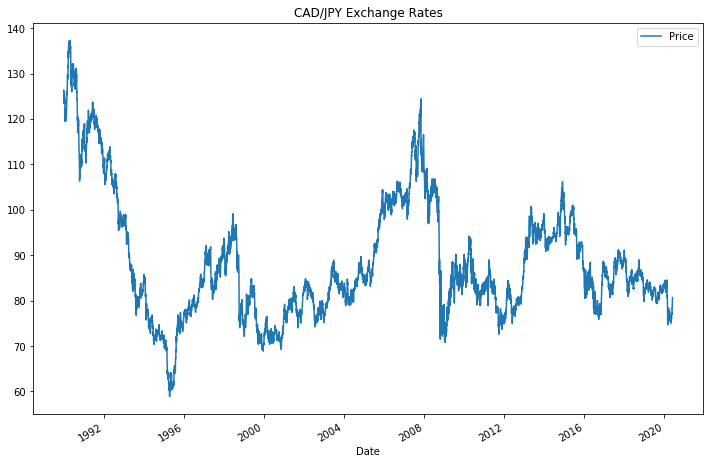

In [74]:
# Plotted just the "Price" column from the dataframe:

cad_jpy_df['Price'].plot(figsize=(12,8), title = "CAD/JPY Exchange Rates", legend = True)


**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** 

Long term the CAD/JPY exchange is fairly stable around 80 to 85. Short term, it has exhibited three substantial spikes and the exchange rates normalize itself with a dip and recovers back to 80 to 85 range. 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [75]:
import statsmodels.api as sm

# Applied the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:

cad_noise, cad_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [76]:
# Created a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:

cad_jpy_exchange = cad_jpy_df['Price'].to_frame()

cad_jpy_exchange['noise'] = cad_noise

cad_jpy_exchange['trend'] = cad_trend

cad_jpy_exchange.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


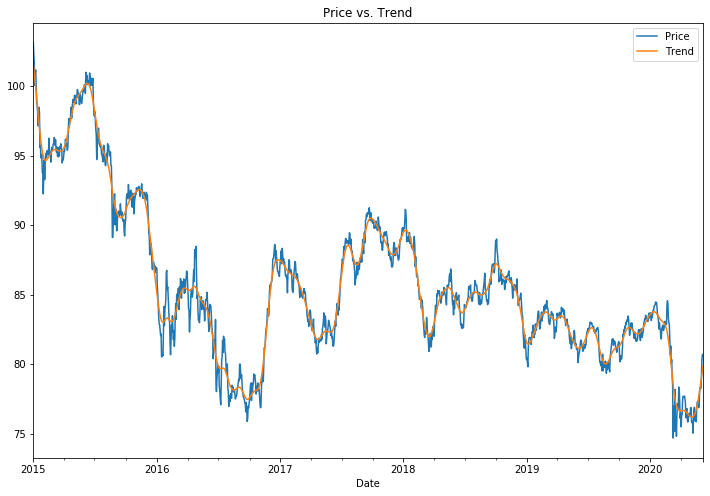

In [77]:
# Plotted the Exchange Rate Price vs. the Trend for 2015 to the present

cad_jpy_plot = cad_jpy_exchange.loc["2015-01-01":, :]

ax = cad_jpy_plot['Price'].plot(figsize = (12,8), title = "Price vs. Trend")

cad_jpy_plot['trend'].plot(ax=ax)

ax.legend(['Price', 'Trend'])

**Question:** Do you see any patterns, long-term and/or short?



**Answer:** 

The Hodrick-Prescoot Filter results is consistent with the time series plot. 
Long term the CAD/JPY exchange is fairly stable around 80 to 85. Short term, the exchange rates spikes up and normalizes itself after dipping below 80. 

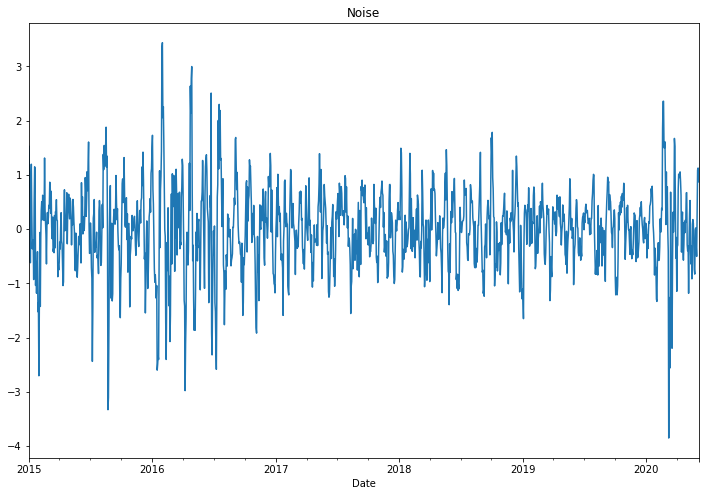

In [78]:
# Plotted the Settle Noise

cad_jpy_plot['noise'].plot(figsize = (12,8), title = "Noise")

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [79]:
# Created a series using "Price" percentage returns, drop any nan"s, and check the results:

returns = (cad_jpy_df[["Price"]].pct_change() * 100)

returns = returns.replace(-np.inf, np.nan).dropna()

returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [80]:
from statsmodels.tsa.arima_model import ARMA

# Estimated an ARMA model using statsmodels (use order=(2, 1))

model = ARMA(returns, order = (2,1))

# Fitted the model and assign it to a variable called results

results = model.fit()

In [81]:
# Initialized model summary results:

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Wed, 21 Jul 2021   AIC                          19513.955
Time:                        01:21:47   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.Price    -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.Price    -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.Price     0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1701           +0.0000j           42.1701            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

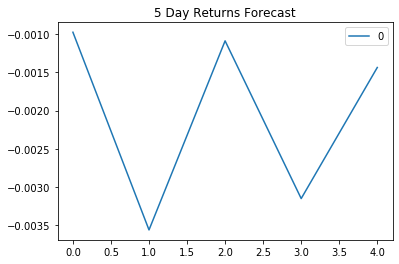

In [82]:
# Plotted the 5 Day Returns Forecast

pd.DataFrame(results.forecast(steps=5)[0]).plot(title = "5 Day Returns Forecast")

**Question:** 

Based on the p-value, is the model a good fit?

**Answer:** 

Based on the results, the model is a great fit since the values of the p-value are less than 0.05.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [84]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:

model = ARIMA(cad_jpy_df.Price.values, order = (5,1,1))

# Fitted the model

results = model.fit()

In [85]:
# Initialized model summary results:

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 21 Jul 2021   AIC                          17507.244
Time:                        01:22:04   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.y      0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.y      0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.y     -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.y      0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.y     -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.y     -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

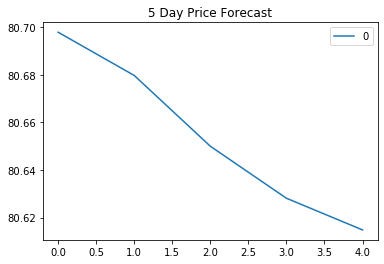

In [87]:
# Plot the 5 Day Price Forecast

pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Price Forecast")

**Question:**

 What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** 

The forecast states that the CAD-JPY exchange rate will go down in the near term.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [89]:
from arch import arch_model

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [ ]:
# Estimate a GARCH model:
# YOUR CODE HERE!

# Fit the model
# YOUR CODE HERE!

In [ ]:
# Summarize the model results
# YOUR CODE HERE!

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
# YOUR CODE HERE!

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
# YOUR CODE HERE!

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** YOUR ANSWER HERE

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * YOUR ANSWER HERE

2. Is the risk of the yen expected to increase or decrease?
    * YOUR ANSWER HERE

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * YOUR ANSWER HERE